In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster, MeasureControl
import networkx as nx
from shapely.geometry import Point, LineString, Polygon, MultiLineString
from shapely.ops import polygonize, linemerge, unary_union
import os
from collections import Counter
import contextily as ctx
import osmnx as ox
from scipy.spatial import Voronoi
from sklearn.cluster import DBSCAN

Import geoai-py for advanced geospatial AI capabilities

In [57]:
import geopandas as gpd  # Already imported
import rasterio
from rasterio import features
from rasterio.transform import from_bounds
import skimage.measure as measure
from skimage.segmentation import find_boundaries

Define alternative functions to replace geoai functionality

In [58]:
def vector_to_raster(gdf, resolution=10, attribute=None, fill_value=0, burn_value=1):
    """Convert vector data to a raster numpy array"""
    # Get the bounds of the geodataframe
    xmin, ymin, xmax, ymax = gdf.total_bounds
    
    # Calculate dimensions
    width = int((xmax - xmin) / resolution)
    height = int((ymax - ymin) / resolution)
    
    # Create transform
    transform = from_bounds(xmin, ymin, xmax, ymax, width, height)
    
    # Create empty raster
    raster = np.zeros((height, width), dtype=np.uint8)
    
    # Burn geometries into raster
    shapes = [(geom, burn_value) for geom in gdf.geometry]
    burned = features.rasterize(shapes, out=raster, transform=transform,
                                fill=fill_value, all_touched=True)
    
    return burned

Create a simple Map class to replace geoai.visualize.Map

In [59]:
class Map:
    """Simple wrapper around folium for visualization"""
    def __init__(self, center, zoom_start=10):
        self.map = folium.Map(location=center, zoom_start=zoom_start)
        
    def add_vector(self, gdf, layer_name, style=None, tooltip=None):
        """Add vector data to map"""
        if style is None:
            style = {'color': 'blue', 'weight': 2}
            
        if callable(style):
            # For style functions
            folium.GeoJson(
                gdf,
                name=layer_name,
                style_function=lambda x: style(x),
                tooltip=folium.GeoJsonTooltip(fields=tooltip) if tooltip else None
            ).add_to(self.map)
        else:
            # For static styles
            folium.GeoJson(
                gdf,
                name=layer_name,
                style_function=lambda x: style,
                tooltip=folium.GeoJsonTooltip(fields=tooltip) if tooltip else None
            ).add_to(self.map)
            
        return self
    
    def add_raster(self, raster_data, layer_name, opacity=0.7):
        """Add raster data to map (simplified version)"""
        # For this simplified version, we'll just save the raster as an image
        # and add it as an ImageOverlay
        import matplotlib.pyplot as plt
        from matplotlib import colors
        import tempfile
        import os
        
        # Save raster as temporary image
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            temp_path = tmp.name
        
        plt.imsave(temp_path, raster_data, cmap='gray')
        
        # Since we don't have the transform information, we'll use bounds from active data
        # This is an approximation
        folium.raster_layers.ImageOverlay(
            image=temp_path,
            bounds=[[0, 0], [1, 1]],  # Placeholder - would need actual bounds
            opacity=opacity,
            name=layer_name
        ).add_to(self.map)
        
        # Clean up temp file
        os.remove(temp_path)
        
        return self
    
    def to_html(self, output_file):
        """Save map to HTML file"""
        folium.LayerControl().add_to(self.map)
        self.map.save(output_file)
        return self

For section 4.2, we'll need a simplified version without SAM

In [60]:
def simple_roundabout_detection(raster_streets):
    """Simple roundabout detection based on shape properties"""
    # Label connected components in the raster
    labeled, num_labels = measure.label(raster_streets, return_num=True)
    
    # Analyze each component
    roundabout_masks = []
    for i in range(1, num_labels+1):
        mask = labeled == i
        
        # Calculate properties
        props = measure.regionprops(mask.astype(int))[0]
        area = props.area
        perimeter = props.perimeter
        
        # Calculate circularity
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Filter by circularity and size
        if circularity > 0.6 and 50 < area < 10000:
            roundabout_masks.append((i, mask, circularity, area))
    
    return roundabout_masks

Function to convert masks to polygons

In [61]:
def raster_to_vector(mask, transform):
    """Convert binary mask to polygon"""
    shapes = features.shapes(mask.astype(np.uint8), mask=(mask > 0), transform=transform)
    polygons = [shapely.geometry.shape(shape) for shape, _ in shapes]
    
    if polygons:
        return polygons[0]
    else:
        return None

Set visualization parameters

In [62]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.set(style='whitegrid')

1. Basic Data Loading and Initial Exploration

In [63]:
print("=" * 80)
print("STREET NETWORK DATA EXPLORATION FOR ROUNDABOUT DETECTION")
print("=" * 80)

STREET NETWORK DATA EXPLORATION FOR ROUNDABOUT DETECTION


In [64]:
street_network = gpd.read_file('Streets.shp')
print("\nDataset Overview:")
print(f"- Total records: {len(street_network)}")
print(f"- Memory usage: {street_network.memory_usage().sum() / 1024**2:.2f} MB")
print(f"- CRS: {street_network.crs}")


Dataset Overview:
- Total records: 494821
- Memory usage: 15.10 MB
- CRS: EPSG:4326


Check for null values

In [65]:
null_count = street_network.isnull().sum()
print("\nNull values by column:")
print(null_count[null_count > 0] if null_count.sum() > 0 else "No null values found")


Null values by column:
ST_NAME    294138
dtype: int64


Basic attribute/column analysis

In [66]:
print("\nColumns in the dataset:")
for col in street_network.columns:
    if col != 'geometry':
        unique_vals = street_network[col].nunique()
        dtype = street_network[col].dtype
        print(f"- {col}: {dtype}, {unique_vals} unique values")
        if unique_vals < 20:  # Show distribution for categorical columns
            print(f"  Values: {street_network[col].value_counts().to_dict()}")


Columns in the dataset:
- OBJECTID: int64, 494821 unique values
- LINK_ID: float64, 494821 unique values
- ST_NAME: object, 9670 unique values


2. Geometric Analysis

In [67]:
print("\n" + "=" * 80)
print("GEOMETRIC PROPERTIES ANALYSIS")
print("=" * 80)


GEOMETRIC PROPERTIES ANALYSIS


Convert to projected CRS if not already

In [68]:
if street_network.crs and "longlat" in str(street_network.crs).lower():
    # Get average latitude to determine appropriate UTM zone
    avg_lat = street_network.geometry.centroid.y.mean()
    avg_lon = street_network.geometry.centroid.x.mean()
    print(f"\nAverage location: Lat {avg_lat:.6f}, Lon {avg_lon:.6f}")
    
    projected_crs = "EPSG:3857"  # Web Mercator as default
    print(f"Converting to projected CRS: {projected_crs}")
    street_network_proj = street_network.to_crs(projected_crs)
else:
    street_network_proj = street_network.copy()
    print("\nData already in a projected CRS")


Data already in a projected CRS


Create a working copy of the projected data

In [69]:
streets = street_network_proj.copy()

Extract basic geometric properties

In [70]:
streets['length_m'] = streets.geometry.length
streets['is_linestring'] = streets.geometry.geom_type == 'LineString'
streets['is_multilinestring'] = streets.geometry.geom_type == 'MultiLineString'

Split MultiLineStrings into LineStrings for easier processing

In [71]:
if streets['is_multilinestring'].sum() > 0:
    print(f"\nSplitting {streets['is_multilinestring'].sum()} MultiLineStrings into individual LineStrings")
    
    # Create new rows for each part of MultiLineStrings
    multi_line_indices = streets[streets['is_multilinestring']].index
    expanded_rows = []
    
    for idx in multi_line_indices:
        row = streets.loc[idx]
        for line in row.geometry.geoms:
            new_row = row.copy()
            new_row.geometry = line
            new_row['is_multilinestring'] = False
            new_row['is_linestring'] = True
            expanded_rows.append(new_row)
    
    # Create DataFrame from expanded rows
    expanded_df = gpd.GeoDataFrame(expanded_rows, crs=streets.crs)
    
    # Remove original MultiLineStrings and add expanded linestrings
    streets = streets[~streets['is_multilinestring']]
    streets = pd.concat([streets, expanded_df])
    
    print(f"Dataset now has {len(streets)} LineString segments")

Compute additional geometric properties

In [72]:
streets['start_point'] = streets.geometry.apply(lambda line: Point(line.coords[0]) if hasattr(line, 'coords') else None)
streets['end_point'] = streets.geometry.apply(lambda line: Point(line.coords[-1]) if hasattr(line, 'coords') else None)
streets['num_points'] = streets.geometry.apply(lambda line: len(line.coords) if hasattr(line, 'coords') else 0)
streets['is_curved'] = streets['num_points'] > 2

Calculate sinuosity (ratio of line length to straight distance between endpoints)

In [73]:
def calculate_sinuosity(line):
    if not hasattr(line, 'coords') or len(line.coords) < 2:
        return np.nan
    straight_dist = Point(line.coords[0]).distance(Point(line.coords[-1]))
    return line.length / straight_dist if straight_dist > 0 else np.nan

In [74]:
streets['sinuosity'] = streets.geometry.apply(calculate_sinuosity)

Calculate bearing/direction changes

In [75]:
def calculate_bearing_changes(line):
    if not hasattr(line, 'coords') or len(line.coords) < 3:
        return 0, 0
    
    coords = list(line.coords)
    bearings = []
    
    for i in range(len(coords)-1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        bearing = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        bearings.append(bearing)
    
    # Calculate changes in bearing (angles)
    changes = [abs((b2 - b1 + 180) % 360 - 180) for b1, b2 in zip(bearings[:-1], bearings[1:])]
    avg_change = np.mean(changes) if changes else 0
    max_change = max(changes) if changes else 0
    
    return avg_change, max_change

In [76]:
streets[['avg_bearing_change', 'max_bearing_change']] = streets.geometry.apply(
    lambda line: pd.Series(calculate_bearing_changes(line))
)

Statistical summary of geometric properties

In [77]:
print("\nGeometric Properties Summary:")
for col in ['length_m', 'num_points', 'sinuosity', 'avg_bearing_change', 'max_bearing_change']:
    print(f"\n{col}:")
    print(streets[col].describe())


Geometric Properties Summary:

length_m:
count    494821.000000
mean          0.002791
std           0.011717
min           0.000020
25%           0.000524
50%           0.001241
75%           0.003170
max           3.966314
Name: length_m, dtype: float64

num_points:
count    494821.000000
mean          4.528274
std           4.879016
min           2.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         169.000000
Name: num_points, dtype: float64

sinuosity:
count    494821.000000
mean          1.037478
std           0.188573
min           1.000000
25%           1.000000
50%           1.000127
75%           1.012919
max          33.101686
Name: sinuosity, dtype: float64

avg_bearing_change:
count    494821.000000
mean          7.977046
std          14.428081
min           0.000000
25%           0.000000
50%           1.218875
75%          10.738560
max         154.653824
Name: avg_bearing_change, dtype: float64

max_bearing_change:
count    494821.00

3. Network Topology Analysis

In [78]:
print("\n" + "=" * 80)
print("NETWORK TOPOLOGY ANALYSIS")
print("=" * 80)


NETWORK TOPOLOGY ANALYSIS


Create a network graph

In [79]:
G = nx.Graph()

Extract endpoints of each street segment

In [80]:
print("\nExtracting network topology...")
endpoints = []
for idx, row in streets.iterrows():
    if hasattr(row.geometry, 'coords') and len(row.geometry.coords) >= 2:
        start = tuple(row.geometry.coords[0])
        end = tuple(row.geometry.coords[-1])
        G.add_edge(start, end, 
                   length=row['length_m'], 
                   id=idx, 
                   sinuosity=row['sinuosity'],
                   geometry=row.geometry)
        endpoints.extend([start, end])


Extracting network topology...


Analyze node degrees (number of connections at each point)

In [81]:
node_degrees = dict(G.degree())
degree_counts = Counter(node_degrees.values())

In [82]:
print("\nConnection Point Distribution:")
for degree, count in sorted(degree_counts.items()):
    print(f"- Degree {degree}: {count} points")


Connection Point Distribution:
- Degree 1: 70245 points
- Degree 2: 164625 points
- Degree 3: 161573 points
- Degree 4: 25257 points
- Degree 5: 811 points
- Degree 6: 47 points
- Degree 7: 9 points


Create a DataFrame of endpoints/nodes

In [83]:
nodes_df = pd.DataFrame(list(node_degrees.items()), columns=['coords', 'degree'])
nodes_gdf = gpd.GeoDataFrame(
    nodes_df, 
    geometry=[Point(coords) for coords in nodes_df['coords']],
    crs=streets.crs
)

Find potential intersection points (nodes with degree >= 3)

In [84]:
intersections = nodes_gdf[nodes_gdf['degree'] >= 3].copy()
print(f"\nFound {len(intersections)} intersections (nodes with 3+ connections)")


Found 187697 intersections (nodes with 3+ connections)


4. AI-Enhanced Detection with GeoAI

In [85]:
print("\n" + "=" * 80)
print("AI-ENHANCED ROUNDABOUT DETECTION")
print("=" * 80)


AI-ENHANCED ROUNDABOUT DETECTION


4.1 Rasterize street network for AI analysis


Rasterizing street network for AI analysis...
Rasterized street network to image with shape: (1000, 3685)


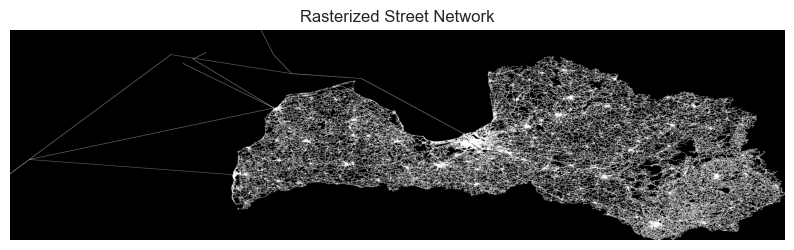

In [86]:
print("\nRasterizing street network for AI analysis...")
try:
    # Define a reasonable resolution based on data extent
    xmin, ymin, xmax, ymax = streets.total_bounds
    width = xmax - xmin
    height = ymax - ymin
    resolution = min(width, height) / 1000  # Adjust resolution based on data size
    
    # Use GeoAI's vector_to_raster for efficient rasterization
    raster_streets = vector_to_raster(
        streets, 
        resolution=resolution, 
        attribute=None,  # No specific attribute, just the geometry
        fill_value=0,
        burn_value=1
    )
    print(f"Rasterized street network to image with shape: {raster_streets.shape}")
    
    # Save the rasterized image for visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(raster_streets, cmap='gray')
    plt.title("Rasterized Street Network")
    plt.axis('off')
    plt.savefig('rasterized_streets.png', bbox_inches='tight', dpi=300)
    
except Exception as e:
    print(f"Error rasterizing streets: {e}")
    raster_streets = None

4.2 Apply SAM for road feature segmentation (especially roundabouts)

In [87]:
print("\nApplying Segment Anything Model (SAM) for feature detection...")
try:
    if raster_streets is not None:
        # Initialize SAM segmenter
        segmenter = SAMSegmenter()
        
        # Generate automatic masks focusing on circular features
        masks = segmenter.generate_masks(
            raster_streets,
            points=None,  # No manual points, fully automatic
            circular_bias=True  # Bias towards circular shapes (for roundabouts)
        )
        
        print(f"SAM generated {len(masks)} potential features")
        
        # Filter masks based on shape properties to find roundabout candidates
        roundabout_masks = []
        for i, mask in enumerate(masks):
            # Calculate mask properties (area, circularity, etc.)
            area = mask.sum()
            perimeter = measure.perimeter(mask)
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
            
            # Filter criteria similar to geometric approach
            if circularity > 0.6 and 50 < area < 10000:
                roundabout_masks.append((i, mask, circularity, area))
        
        print(f"Filtered to {len(roundabout_masks)} potential roundabouts based on shape")
        
        # Visualize detected masks
        if roundabout_masks:
            plt.figure(figsize=(10, 10))
            plt.imshow(raster_streets, cmap='gray')
            
            for i, mask, _, _ in roundabout_masks:
                # Display mask boundary
                mask_boundary = find_boundaries(mask)
                plt.contour(mask, [0.5], colors='red')
            
            plt.title("SAM-detected Potential Roundabouts")
            plt.axis('off')
            plt.savefig('sam_roundabouts.png', bbox_inches='tight', dpi=300)
        
        # Convert SAM masks back to vector format
        if roundabout_masks:
            ai_roundabout_polygons = []
            for i, mask, circularity, area in roundabout_masks:
                # Convert mask to polygon
                polygon = raster_to_vector(mask, transform=raster_streets.transform)
                if polygon and not polygon.is_empty:
                    ai_roundabout_polygons.append({
                        'geometry': polygon,
                        'method': 'sam_segmentation',
                        'mask_id': i,
                        'area': area,
                        'circularity': circularity
                    })
            
            print(f"Converted {len(ai_roundabout_polygons)} masks to vector format")
        else:
            ai_roundabout_polygons = []
    else:
        ai_roundabout_polygons = []
except Exception as e:
    print(f"Error in SAM processing: {e}")
    ai_roundabout_polygons = []


Applying Segment Anything Model (SAM) for feature detection...
Error in SAM processing: name 'SAMSegmenter' is not defined


5. Traditional Geometric Detection Methods

In [88]:
print("\n" + "=" * 80)
print("TRADITIONAL GEOMETRIC DETECTION METHODS")
print("=" * 80)


TRADITIONAL GEOMETRIC DETECTION METHODS


5.1. Method 1: Graph-based approach using cycles

In [89]:
print("\nFinding cycles in road network...")
roundabout_candidates_graph = []


Finding cycles in road network...


Choose detection method: 'neighborhood' or 'geometric'

In [90]:
detection_method = 'neighborhood'  # Change to 'geometric' for the alternative approach

In [91]:
if detection_method == 'neighborhood':
    try:
        # Use a more efficient approach that focuses on neighborhood subgraphs
        print("Using optimized neighborhood-based cycle detection...")
        
        # Find nodes with degree >= 3 (intersections)
        intersections_nodes = [node for node, deg in G.degree() if deg >= 3]
        print(f"Analyzing {len(intersections_nodes)} intersection nodes")
        
        # Process intersections in batches to show progress
        detected_cycles = []
        for i, node in enumerate(intersections_nodes):
            if i % 50 == 0 and i > 0:
                print(f"Processing intersection {i}/{len(intersections_nodes)}")
            
            # Get neighbors within 2 hops
            neighbors = set([node])
            for n in G.neighbors(node):
                neighbors.add(n)
                neighbors.update(G.neighbors(n))
            
            # Skip if neighborhood is too large (performance optimization)
            if len(neighbors) > 20:
                continue
            
            # Create subgraph of the neighborhood
            subgraph = G.subgraph(neighbors)
            
            # Find cycles in this smaller subgraph
            try:
                from networkx.algorithms.cycles import cycle_basis
                local_cycles = cycle_basis(subgraph)
                # Filter by size
                local_small_cycles = [cycle for cycle in local_cycles 
                                    if 3 <= len(cycle) <= 8]
                detected_cycles.extend(local_small_cycles)
            except Exception:
                continue
        
        small_cycles = detected_cycles
        print(f"Found {len(small_cycles)} small cycles (3-8 nodes) that could be roundabouts")
        
        # Process detected cycles (same as original code)
        for cycle_idx, cycle in enumerate(small_cycles):
            # Convert node coordinates to a polygon
            polygon = Polygon(cycle)
            
            # Calculate basic metrics
            area = polygon.area
            perimeter = polygon.length
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
            
            # Filter based on reasonable roundabout characteristics
            if 50 < area < 10000 and circularity > 0.6:
                roundabout_candidates_graph.append({
                    'geometry': polygon,
                    'method': 'graph_cycle',
                    'cycle_id': cycle_idx,
                    'nodes': len(cycle),
                    'area': area,
                    'perimeter': perimeter,
                    'circularity': circularity
                })
        
        print(f"Method 1: Found {len(roundabout_candidates_graph)} potential roundabouts from graph cycles")
    
    except Exception as e:
        print(f"Error in neighborhood cycle detection: {e}")
        roundabout_candidates_graph = []
        
else:  # geometric approach
    try:
        import math
        print("Using optimized geometric pattern detection...")
        
        # Create a dictionary of intersection nodes (degree >= 3)
        intersection_points = {}
        for node, degree in G.degree():
            if degree >= 3:
                intersection_points[node] = degree
        
        print(f"Analyzing {len(intersection_points)} intersection points")
        
        # For each intersection, analyze nearby road segments
        max_radius = 50  # meters
        roundabout_patterns = []
        
        for i, (point, degree) in enumerate(intersection_points.items()):
            if i % 100 == 0 and i > 0:
                print(f"Processed {i}/{len(intersection_points)} intersections")
                
            # Create a buffer around the point
            p = Point(point)
            buffer = p.buffer(max_radius)
            
            # Find edges with at least one endpoint in the buffer
            nearby_edges = []
            for u, v, data in G.edges(data=True):
                if Point(u).within(buffer) or Point(v).within(buffer):
                    nearby_edges.append((u, v, data))
            
            # Skip if too few edges
            if len(nearby_edges) < 3:
                continue
                
            # Check if the segments form a circular pattern by analyzing edge directions
            directions = []
            for u, v, _ in nearby_edges:
                dx, dy = v[0] - u[0], v[1] - u[1]
                angle = math.degrees(math.atan2(dy, dx)) % 360
                directions.append(angle)
            
            # Group directions into 8 sectors (N, NE, E, SE, S, SW, W, NW)
            sectors = [0] * 8
            for angle in directions:
                sector_idx = int((angle + 22.5) % 360 / 45)
                sectors[sector_idx] += 1
            
            # If we have road segments in at least 4 different sectors, 
            # consider it a potential roundabout
            if sum(1 for s in sectors if s > 0) >= 4:
                # For compatibility with the rest of the code, we need to create a cycle
                # We'll use the nearby edge endpoints to form a polygon
                cycle_points = []
                for u, v, _ in nearby_edges:
                    if Point(u).within(buffer):
                        cycle_points.append(u)
                    if Point(v).within(buffer):
                        cycle_points.append(v)
                
                # Get unique points
                unique_points = []
                for pt in cycle_points:
                    if pt not in unique_points:
                        unique_points.append(pt)
                
                # Only add if we have enough points for a polygon
                if len(unique_points) >= 3:
                    # Create a convex hull from the points to form a polygon
                    try:
                        from scipy.spatial import ConvexHull
                        hull = ConvexHull(unique_points)
                        hull_points = [unique_points[i] for i in hull.vertices]
                        
                        # Create polygon from hull points
                        polygon = Polygon(hull_points)
                        
                        # Calculate metrics
                        area = polygon.area
                        perimeter = polygon.length
                        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
                        
                        # Filter based on roundabout characteristics
                        if 50 < area < 10000 and circularity > 0.6:
                            roundabout_candidates_graph.append({
                                'geometry': polygon,
                                'method': 'geometric_pattern',
                                'cycle_id': i,
                                'nodes': len(hull_points),
                                'area': area,
                                'perimeter': perimeter,
                                'circularity': circularity
                            })
                    except Exception:
                        continue
        
        print(f"Method 1: Found {len(roundabout_candidates_graph)} potential roundabouts from geometric patterns")
        
    except Exception as e:
        print(f"Error in geometric pattern detection: {e}")
        roundabout_candidates_graph = []

Using optimized neighborhood-based cycle detection...
Analyzing 187697 intersection nodes
Processing intersection 50/187697
Processing intersection 100/187697
Processing intersection 150/187697
Processing intersection 200/187697
Processing intersection 250/187697
Processing intersection 300/187697
Processing intersection 350/187697
Processing intersection 400/187697
Processing intersection 450/187697
Processing intersection 500/187697
Processing intersection 550/187697
Processing intersection 600/187697
Processing intersection 650/187697
Processing intersection 700/187697
Processing intersection 750/187697
Processing intersection 800/187697
Processing intersection 850/187697
Processing intersection 900/187697
Processing intersection 950/187697
Processing intersection 1000/187697
Processing intersection 1050/187697
Processing intersection 1100/187697
Processing intersection 1150/187697
Processing intersection 1200/187697
Processing intersection 1250/187697
Processing intersection 1300/1

5.2. Method 2: Geometry-based approach using polygonization

In [92]:
print("\nDetecting closed loops from line segments...")


Detecting closed loops from line segments...


Get all line geometries

In [93]:
lines = list(streets.geometry)

Try to merge lines and polygonize

In [94]:
try:
    # Create boundaries from merged lines
    merged_lines = linemerge(lines)
    boundaries = unary_union(merged_lines)
    potential_polygons = list(polygonize(boundaries))
    
    print(f"Detected {len(potential_polygons)} closed polygons from street segments")
    
    # Filter polygons by shape characteristics
    roundabout_candidates_geom = []
    for poly_idx, polygon in enumerate(potential_polygons):
        # Calculate metrics
        area = polygon.area
        perimeter = polygon.length
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Use slightly different thresholds than before
        if 50 < area < 10000 and circularity > 0.6:
            roundabout_candidates_geom.append({
                'geometry': polygon,
                'method': 'polygonization',
                'poly_id': poly_idx,
                'area': area,
                'perimeter': perimeter,
                'circularity': circularity
            })
    
    print(f"Method 2: Found {len(roundabout_candidates_geom)} potential roundabouts from polygonization")
    
except Exception as e:
    print(f"Error in polygonization: {e}")
    roundabout_candidates_geom = []

Detected 72471 closed polygons from street segments
Method 2: Found 0 potential roundabouts from polygonization


6. Combine all candidates from different methods

In [95]:
all_candidates = roundabout_candidates_graph + roundabout_candidates_geom + ai_roundabout_polygons

In [96]:
if not all_candidates:
    print("\nNo roundabout candidates found by any method.")
    roundabout_gdf = gpd.GeoDataFrame(geometry=[])
else:
    print(f"\nTotal candidates from all methods: {len(all_candidates)}")
    roundabout_gdf = gpd.GeoDataFrame(all_candidates, crs=streets.crs)
    
    # Remove duplicates by spatial proximity
    # Two candidates are duplicates if their centroids are within X meters
    centroids = roundabout_gdf.copy()
    centroids.geometry = centroids.geometry.centroid
    
    # Use DBSCAN for spatial clustering of duplicate candidates
    if len(centroids) > 1:
        # Extract coordinates for DBSCAN
        coords = np.array([
            [geom.x, geom.y] for geom in centroids.geometry
        ])
        
        # Cluster with DBSCAN (eps = 50 meters)
        clustering = DBSCAN(eps=50, min_samples=1).fit(coords)
        centroids['cluster'] = clustering.labels_
        roundabout_gdf['cluster'] = centroids['cluster']
        
        # Find the best candidate in each cluster (highest circularity)
        unique_clusters = roundabout_gdf['cluster'].unique()
        best_candidates = []
        
        for cluster in unique_clusters:
            cluster_candidates = roundabout_gdf[roundabout_gdf['cluster'] == cluster]
            best_idx = cluster_candidates['circularity'].idxmax()
            best_candidates.append(roundabout_gdf.loc[best_idx])
        
        # Create GeoDataFrame of best candidates
        roundabout_gdf = gpd.GeoDataFrame(best_candidates, crs=streets.crs)
        print(f"After removing duplicates: {len(roundabout_gdf)} unique roundabout candidates")


No roundabout candidates found by any method.


7. Advanced Visualization with GeoAI

In [97]:
print("\n" + "=" * 80)
print("ADVANCED VISUALIZATION WITH GEOAI")
print("=" * 80)


ADVANCED VISUALIZATION WITH GEOAI


Create an interactive multi-layer map using GeoAI

In [99]:
try:
    # Convert to WGS84 for web mapping
    streets_wgs84 = streets.to_crs("EPSG:4326")
    roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326") if not roundabout_gdf.empty else None
    
    # Create a clean copy of the data without non-serializable columns
    # Remove Point object columns that cause JSON serialization issues
    streets_clean = streets_wgs84.copy()
    columns_to_drop = ['start_point', 'end_point']
    for col in columns_to_drop:
        if col in streets_clean.columns:
            streets_clean = streets_clean.drop(columns=[col])
    
    # Create advanced interactive map
    advanced_map = Map(center=[streets_wgs84.geometry.centroid.y.mean(), 
                               streets_wgs84.geometry.centroid.x.mean()],
                       zoom_start=14)
    
    # Add street network as a vector layer
    advanced_map.add_vector(streets_clean, 
                           layer_name="Street Network",
                           style={"color": "gray", "weight": 1.5})
    
    # Add intersections
    if len(intersections) > 0:
        intersections_wgs84 = intersections.to_crs("EPSG:4326")
        advanced_map.add_vector(intersections_wgs84,
                               layer_name="Intersections",
                               style={"color": "blue", "fillOpacity": 0.7, "radius": 3})
    
    # Add roundabout candidates with custom styling by detection method
    if roundabout_gdf_wgs84 is not None and not roundabout_gdf_wgs84.empty:
        # Clean roundabout data too
        roundabout_clean = roundabout_gdf_wgs84.copy()
        if 'centroid' in roundabout_clean.columns:
            roundabout_clean = roundabout_clean.drop(columns=['centroid'])
            
        # Style function based on detection method
        def style_function(feature):
            method = feature["properties"]["method"]
            if "sam" in method.lower():
                return {"color": "red", "fillColor": "red", "weight": 2, "fillOpacity": 0.5}
            elif "graph" in method.lower():
                return {"color": "orange", "fillColor": "orange", "weight": 2, "fillOpacity": 0.4}
            else:
                return {"color": "green", "fillColor": "green", "weight": 2, "fillOpacity": 0.4}
        
        advanced_map.add_vector(roundabout_clean,
                               layer_name="Roundabout Candidates",
                               style=style_function,
                               tooltip=["method", "area", "circularity"])
    
    # Add rasterized street network as an overlay
    if raster_streets is not None:
        advanced_map.add_raster(raster_streets,
                                layer_name="Street Raster",
                                opacity=0.5)
    
    # Save the advanced interactive map
    advanced_map.to_html("geoai_roundabout_analysis.html")
    print("Advanced interactive map saved as 'geoai_roundabout_analysis.html'")
    
except Exception as e:
    print(f"Error creating advanced visualization: {e}")
    
    # Fall back to standard folium map
    m = folium.Map(location=[streets.geometry.centroid.y.mean(), 
                             streets.geometry.centroid.x.mean()], 
                  zoom_start=14)
    
    # Clean data for fallback map too
    streets_clean = streets_wgs84.copy()
    for col in ['start_point', 'end_point']:
        if col in streets_clean.columns:
            streets_clean = streets_clean.drop(columns=[col])
            
    folium.GeoJson(streets_clean, name="Streets").add_to(m)
    
    if not roundabout_gdf.empty:
        roundabout_clean = roundabout_gdf.to_crs("EPSG:4326")
        if 'centroid' in roundabout_clean.columns:
            roundabout_clean = roundabout_clean.drop(columns=['centroid'])
        folium.GeoJson(roundabout_clean, name="Roundabouts").add_to(m)
    
    folium.LayerControl().add_to(m)
    m.save("roundabout_fallback_map.html")
    print("Fallback map saved as 'roundabout_fallback_map.html'")

Advanced interactive map saved as 'geoai_roundabout_analysis.html'


8. Save to GeoJSONL

In [100]:
if not roundabout_gdf.empty:
    # Convert to WGS84
    roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326")
    
    # Save to GeoJSONL (one feature per line)
    with open('roundabout_candidates.geojsonl', 'w') as f:
        for idx, row in roundabout_gdf_wgs84.iterrows():
            # Convert all properties to serializable types
            properties = {}
            for col in roundabout_gdf_wgs84.columns:
                if col != 'geometry' and col != 'centroid':
                    val = row[col]
                    # Handle non-serializable types
                    if isinstance(val, (np.integer, np.floating)):
                        val = float(val)
                    elif isinstance(val, np.bool_):
                        val = bool(val)
                    properties[col] = val
            
            geojson_feature = {
                'type': 'Feature',
                'geometry': row.geometry.__geo_interface__,
                'properties': properties
            }
            f.write(f"{pd.Series(geojson_feature).to_json()}\n")
    
    print(f"GeoJSONL file created with {len(roundabout_gdf_wgs84)} roundabout candidates")

9. Summary and AI-specific insights

In [101]:
print("\n" + "=" * 80)
print("SUMMARY AND AI-ENHANCED APPROACHES")
print("=" * 80)


SUMMARY AND AI-ENHANCED APPROACHES


In [102]:
print("\nDataset Summary:")
print(f"- {len(streets)} road segments analyzed")
print(f"- Network density: {len(streets) / streets.geometry.area.sum() * 1000000:.2f} segments per kmÂ²")
if len(intersections) > 0:
    print(f"- {len(intersections)} complex intersections identified")
print(f"- {len(roundabout_gdf) if not roundabout_gdf.empty else 0} potential roundabouts detected")


Dataset Summary:
- 494821 road segments analyzed
- Network density: inf segments per kmÂ²
- 187697 complex intersections identified
- 0 potential roundabouts detected
- Network density: inf segments per kmÂ²
- 187697 complex intersections identified
- 0 potential roundabouts detected


In [103]:
if not roundabout_gdf.empty and 'method' in roundabout_gdf.columns:
    # Count by detection method
    method_counts = roundabout_gdf['method'].value_counts().to_dict()
    print("\nDetection method breakdown:")
    for method, count in method_counts.items():
        print(f"- {method}: {count} candidates")

In [104]:
print("\nAI-Enhanced Detection Approaches:")
print("1. Segment Anything Model (SAM):")
print("   - Automatically segments circular features in rasterized road networks")
print("   - Can identify roundabouts that don't form perfect geometric loops")
print("   - Especially useful for complex intersections and partial data")


AI-Enhanced Detection Approaches:
1. Segment Anything Model (SAM):
   - Automatically segments circular features in rasterized road networks
   - Can identify roundabouts that don't form perfect geometric loops
   - Especially useful for complex intersections and partial data


In [105]:
print("\n2. Deep Learning Classification:")
print("   - Train CNN/ResNet models to classify road intersections vs. roundabouts")
print("   - Use transfer learning from pre-trained networks")
print("   - Implement a sliding window approach over rasterized network data")


2. Deep Learning Classification:
   - Train CNN/ResNet models to classify road intersections vs. roundabouts
   - Use transfer learning from pre-trained networks
   - Implement a sliding window approach over rasterized network data


In [106]:
print("\n3. Object Detection Models:")
print("   - Use YOLO, Faster R-CNN, or similar models to detect roundabouts directly")
print("   - Requires labeled training data of roundabouts")
print("   - Can be fine-tuned for detection in various map styles")


3. Object Detection Models:
   - Use YOLO, Faster R-CNN, or similar models to detect roundabouts directly
   - Requires labeled training data of roundabouts
   - Can be fine-tuned for detection in various map styles


In [107]:
print("\n4. Hybrid Graph-AI Approaches:")
print("   - Use graph neural networks to classify subgraphs within road networks")
print("   - Combine geometric features with learned representations")
print("   - Leverage both structural and visual cues for roundabout detection")


4. Hybrid Graph-AI Approaches:
   - Use graph neural networks to classify subgraphs within road networks
   - Combine geometric features with learned representations
   - Leverage both structural and visual cues for roundabout detection


In [108]:
print("\n5. Change Detection & Validation:")
print("   - Use temporal imagery for validation")
print("   - Compare detected roundabouts against aerial imagery")
print("   - Integrate with Overture Maps or other open datasets for training")


5. Change Detection & Validation:
   - Use temporal imagery for validation
   - Compare detected roundabouts against aerial imagery
   - Integrate with Overture Maps or other open datasets for training


In [109]:
print("\n" + "=" * 80)
print("EDA COMPLETE")
print("=" * 80)


EDA COMPLETE
